(1000, 500)
Collaborative Filtering:
Train RMSE = 1.3740, Test RMSE = 1.4802


C:\Users\nvqua\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 496, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 248, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 244, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,997,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 500)            │       128,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,136,948 (15.78 MB)

 Trainable params: 4,136,948 (15.78 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 4.2338 - val_loss: 3.1312
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 3.0484 - val_loss: 3.0335
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 2.9605 - val_loss: 3.0391
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 2.8372 - val_loss: 2.9345
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 2.7045 - val_loss: 2.8847
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
CNN Model:
Test RMSE = 1.5343
Top 5 sản phẩm nên gợi ý cho user 5 theo SVD:
[ 96 414 307 463 386] [4.01388537 3.53097272 3.41793752 3.30694657 3.29843733]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Top 5 sản phẩm nên gợi ý cho user 5 theo CNN:
[205 370  29 115 180] [3.2771294 2.9821115 2.9754074 2.8758066 2.8319936]


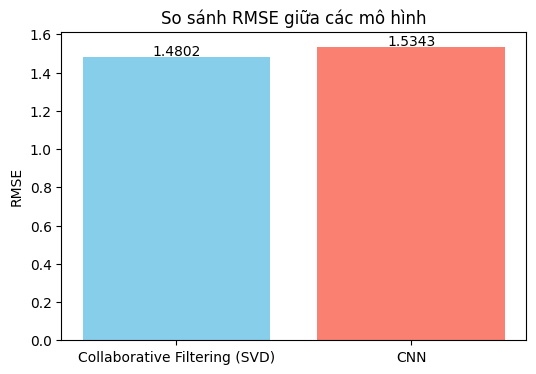

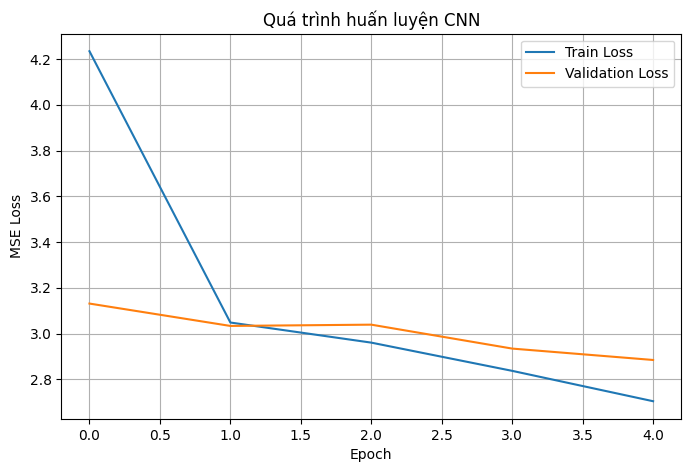

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Số user và item
n_users = 1000
n_items = 500

# Sinh rating ngẫu nhiên từ 1 → 5 (với 20% missing = chưa rating)
np.random.seed(42)
ratings = np.random.randint(1, 6, size=(n_users, n_items)).astype(float)
mask = np.random.rand(n_users, n_items) < 0.2
ratings[mask] = 0  # 0 = chưa đánh giá

ratings_df = pd.DataFrame(ratings)
print(ratings_df.shape)

from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD

# Chia tập train/test
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

# Dùng SVD để factorization
svd = TruncatedSVD(n_components=50, random_state=42)
svd.fit(train)

train_pred = svd.inverse_transform(svd.transform(train))
test_pred  = svd.inverse_transform(svd.transform(test))

# Đánh giá
train_rmse = np.sqrt(mean_squared_error(train[train > 0], train_pred[train > 0]))
test_rmse  = np.sqrt(mean_squared_error(test[test > 0], test_pred[test > 0]))

print("Collaborative Filtering:")
print(f"Train RMSE = {train_rmse:.4f}, Test RMSE = {test_rmse:.4f}")

import tensorflow as tf
from tensorflow.keras import layers, models

# Chuẩn bị dữ liệu cho CNN (reshape thành "ảnh")
X = ratings.reshape((n_users, n_items, 1))  # (1000, 500, 1)
y = ratings.copy()

# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Xây CNN
model = models.Sequential([
    layers.Conv1D(32, kernel_size=5, activation="relu", input_shape=(n_items,1)),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, kernel_size=5, activation="relu"),
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dense(n_items, activation="linear")   # dự đoán toàn bộ item cho mỗi user
])

model.compile(optimizer="adam", loss="mse")
model.summary()

# Train
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

# Đánh giá
cnn_pred = model.predict(X_test)
cnn_rmse = np.sqrt(mean_squared_error(y_test[y_test > 0], cnn_pred[y_test > 0]))

print("CNN Model:")
print(f"Test RMSE = {cnn_rmse:.4f}")

user_id = 5

# Lấy rating gốc của user
user_ratings = ratings[user_id]

# Lấy dự đoán từ SVD
user_pred = test_pred[user_id]

# Tìm top 5 sản phẩm user chưa rating nhưng mô hình dự đoán cao
unrated_items = np.where(user_ratings == 0)[0]
top_items = unrated_items[np.argsort(-user_pred[unrated_items])[:5]]

print("Top 5 sản phẩm nên gợi ý cho user", user_id, "theo SVD:")
print(top_items, user_pred[top_items])


# Lấy input user cho CNN
user_input = X[user_id].reshape(1, n_items, 1)

# Dự đoán
cnn_pred_user = model.predict(user_input)[0]

# Chọn sản phẩm chưa rating nhưng CNN dự đoán cao
unrated_items = np.where(user_ratings == 0)[0]
top_items_cnn = unrated_items[np.argsort(-cnn_pred_user[unrated_items])[:5]]

print("Top 5 sản phẩm nên gợi ý cho user", user_id, "theo CNN:")
print(top_items_cnn, cnn_pred_user[top_items_cnn])

import matplotlib.pyplot as plt

# === 1. So sánh RMSE giữa các mô hình ===
models = ["Collaborative Filtering (SVD)", "CNN"]
rmse_values = [test_rmse, cnn_rmse]

plt.figure(figsize=(6,4))
plt.bar(models, rmse_values, color=["skyblue", "salmon"])
plt.title("So sánh RMSE giữa các mô hình")
plt.ylabel("RMSE")
for i, v in enumerate(rmse_values):
    plt.text(i, v + 0.01, f"{v:.4f}", ha="center", fontsize=10)
plt.show()

# === 2. Visualize quá trình train CNN ===
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Quá trình huấn luyện CNN")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

